<a href="https://colab.research.google.com/github/Farhadi71/SPML-CNN/blob/main/DAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising Autoencoder
In this notebook, you are going to build and train a denoising autoencoder. The purpose of an autoencoder, a form of neural network, is to develop codings for data. 

An autoencoder has two parts: an encoder and a decoder. The encoder modifies the input data and produces a representation for the input in a smaller dimension, and the decoding function reconstructs the input data from the encoded representation. 

A denoising autoencoder is an autoencoder that gets noisy data as input and tries to produce the denoised output for that input.

In [91]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

**For this question, it's highly recommended to use a CUDA-enabled environment.**
We'll check for the availability of GPU and set `device` accordingly.

In [92]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

## Preparing the data
You'll use [Fashion MNIST](https://en.wikipedia.org/wiki/Fashion_MNIST) dataset to train your DAE.

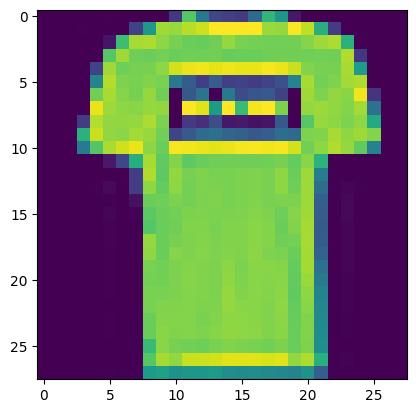

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


In [93]:
fm_train_set = datasets.FashionMNIST(root='./', train=True, download=True, transform=transforms.ToTensor())
fm_test_set = datasets.FashionMNIST(root='./', train=False, download=True, transform=transforms.ToTensor())

# For both the `fm_train_set` and `fm_test_set` only keep the 
# images and leave out the labels.
# Also, normalize the values to be between [0, 1].
##############################
# Your code goes here (5 points)
tensorTrainMax = fm_train_set.data.max()
tensorTrainMin = fm_train_set.data.min()
train_imgs = (fm_train_set.data -  tensorTrainMin)/(tensorTrainMax - tensorTrainMin)

tensorTestMax = fm_test_set.data.max()
tensorTestMin = fm_test_set.data.min()
test_imgs = (fm_test_set.data -  tensorTestMin)/(tensorTestMax - tensorTestMin)
##############################

plt.imshow(train_imgs[1].unsqueeze(0).permute(1, 2, 0))
plt.show()
print(train_imgs.shape, test_imgs.shape)

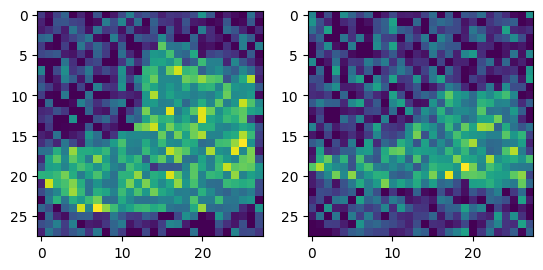

In [107]:
# For each image in our training and test sets,
# create a noisy version of the image.
# We'll use these noisy images as input data for the
# dataset we're going to create. The labels of this dataset
# would be the original images.
##############################
# Your code goes here (10 points)
def AddNoiseToImages(image):
  image = image.clone().detach()
  imageSTD = torch.std(image)
  imageMean = torch.mean(image)
  noise = torch.randn_like(image)* imageSTD + imageMean
  noise = torch.clamp(noise, 0, 1)
  return image + noise

noisy_train_imgs = []
noisy_test_imgs = []

noisy_train_imgs = AddNoiseToImages(train_imgs)
noisy_test_imgs = AddNoiseToImages(test_imgs)
##############################
f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(noisy_train_imgs[0])
f.add_subplot(1, 2, 2)
plt.imshow(noisy_test_imgs[0])
plt.show()

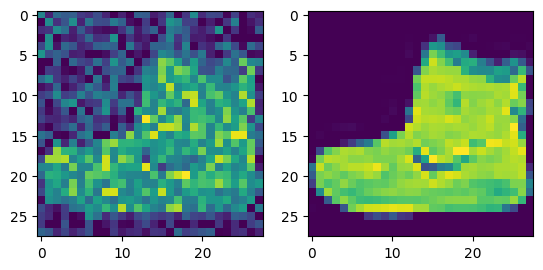

In [95]:
# Now we want to construct our new training and test sets.
# To do so, you'll use the noisy images you've created for each set
# as input for the new dataset and the original Fashion MNIST images as labels.

# Construct `training_set` (data, label) pairs.
##############################
# Your code goes here (10 points)
from torch.utils.data import TensorDataset
train_set = TensorDataset(noisy_train_imgs, train_imgs)
##############################

f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(train_set[0][0]) 
f.add_subplot(1, 2, 2)
plt.imshow(train_set[0][1])
plt.show()

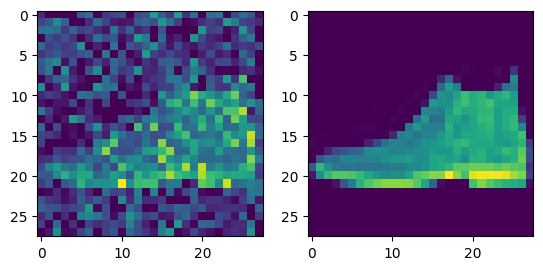

In [96]:
# Construct `test_set` (data, label) pairs.
##############################
# Your code goes here (5 points)
test_set = TensorDataset(noisy_test_imgs, test_imgs)
##############################

f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(test_set[0][0]) 
f.add_subplot(1, 2, 2)
plt.imshow(test_set[0][1])
plt.show()

In [97]:
# Finally, create DataLoaders for the datasets.
# Use a batch size of 128 and enable shuffling.
##############################
# Your code goes here (5 points)
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True)
##############################

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7f214c302a30>,
 <torch.utils.data.dataloader.DataLoader at 0x7f214c302d00>)

## Creating the Model


In this part, you're going to create the DAE model.

In [98]:
# The encoder takes the input and outputs the `encoded representation`.
# Create the encoder using nn.Sequential (You can use the architecture 
# shown in this cell's output).
# Use Conv2d layers followed by ReLU.
# After conv2d layers, flatten the data and use linear layers to
# smoothly transform the output from conv2d layers into the encoded space.
# Set the encoded space dimensions to 10 * 1.
##############################
# Your code goes here (15 points)
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=0),
            nn.ReLU(inplace=True),

            nn.Flatten(start_dim=1, end_dim=-1),

            nn.Linear(288, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 10)
            
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x
encoder = Encoder()
##############################
encoder

Encoder(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): ReLU(inplace=True)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=288, out_features=128, bias=True)
    (10): ReLU(inplace=True)
    (11): Linear(in_features=128, out_features=64, bias=True)
    (12): ReLU(inplace=True)
    (13): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [99]:
# The decoder takes the encoded data generated by the encoder
# and outputs the original input.
# Create the decoder using nn.Sequential.
# Reverse the operations used in encoder.
##############################
# Your code goes here (15 points)
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 288),
            nn.ReLU(inplace=True),

            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),

            nn.ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2),output_padding=0),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1),output_padding=1),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1),output_padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x
decoder = Decoder()
##############################

Now we can construct the DAE by sequentially connecting the `encoder` and `decoder` networks.

In [100]:
DAE = nn.Sequential(encoder, decoder).to(device=device)

## Training the DAE

### Visualizing the Latent Space

During the training, we intend to visualize the *encoded representations* learned by the DAE every 10 epochs. You are going to use T-SNE for this purpose. In order to do so, you have to pass the selected samples to the encoder and retrieve the encoded vectors. Then you can visualize these vectors on a plane and colorize the points according to the class of object each represent.

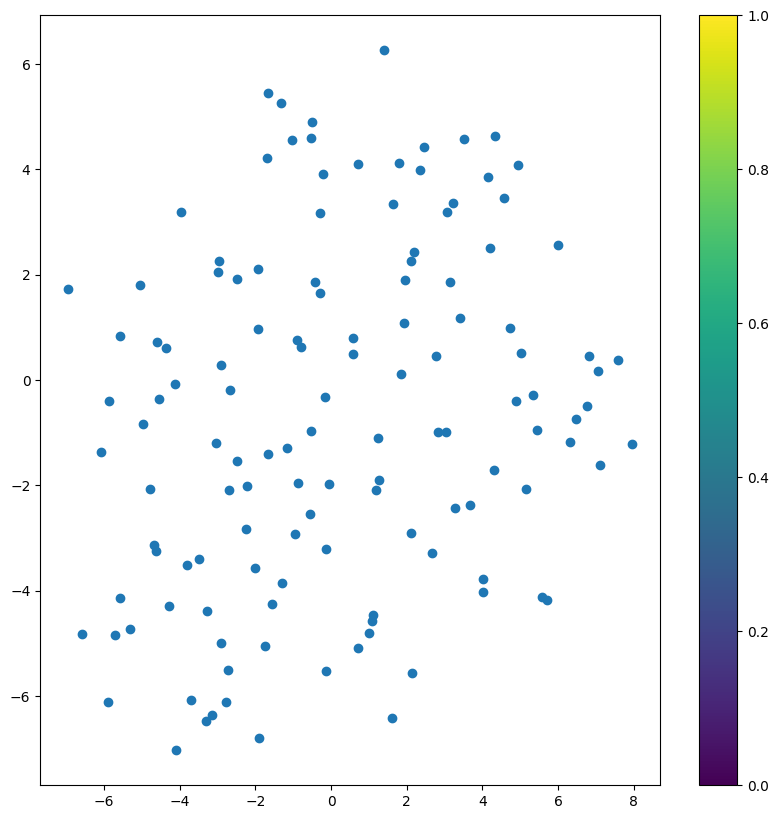

In [101]:
from sklearn.manifold import TSNE

def visualize():
  # Plot the encoded representations of the first 2000
  # images from `fm_train_set` on a plane.
  # You must first pass the images to
  # the encoder to get the encoded vectors, and then you
  # must transform these vectors to 2D space using TSNE
  # and plot the points.
  ##############################
  # Your code goes here (15 points)
  encoder.eval()

  for i, data in enumerate(train_loader):
    img, label = data
    img = img.to(device)
    label=label.to(device)
    imgd=encoder(img.unsqueeze(1).float())
    tsne = TSNE(n_components=2, random_state=0)
    encoded_vectors_2d = tsne.fit_transform(imgd.cpu().detach().numpy())

    
    plt.figure(figsize=(10, 10))
    plt.scatter(encoded_vectors_2d[:, 0], encoded_vectors_2d[:, 1])
    plt.colorbar()
    plt.show()
    break

  encoder.train()
  ##############################

# Testing the function
visualize()

In [102]:
def train(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            # Compute the output.
            # Use GPU for your data if possible.
            ##############################
            # Your code goes here (5 points)
            imgs = imgs.to(device)
            labels=labels.to(device)
            output = model(imgs.unsqueeze(1).float())
            ##############################

            # Using `loss_fn` and `optimizer`, compute the loss and do the backprop step.
            ##############################
            # Your code goes here (5 points)
            loss = loss_fn(output, labels.unsqueeze(1).float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item() * labels.size(0)
            ##############################
            
        print('Epoch {}, Training loss {}'.format(epoch, loss_train / len(train_loader)))
        # Every 10 epochs, we visualize the encoded representations.
        if epoch % 10 == 0:
          visualize()

Epoch 1, Training loss 6.161154934083983
Epoch 2, Training loss 2.728308775531712
Epoch 3, Training loss 2.4114895080452534
Epoch 4, Training loss 2.2529431404843767
Epoch 5, Training loss 2.1602706414804276
Epoch 6, Training loss 2.0961444238101494
Epoch 7, Training loss 2.05381891506313
Epoch 8, Training loss 2.0256244943721464
Epoch 9, Training loss 1.98872774864819
Epoch 10, Training loss 1.9762340638556206


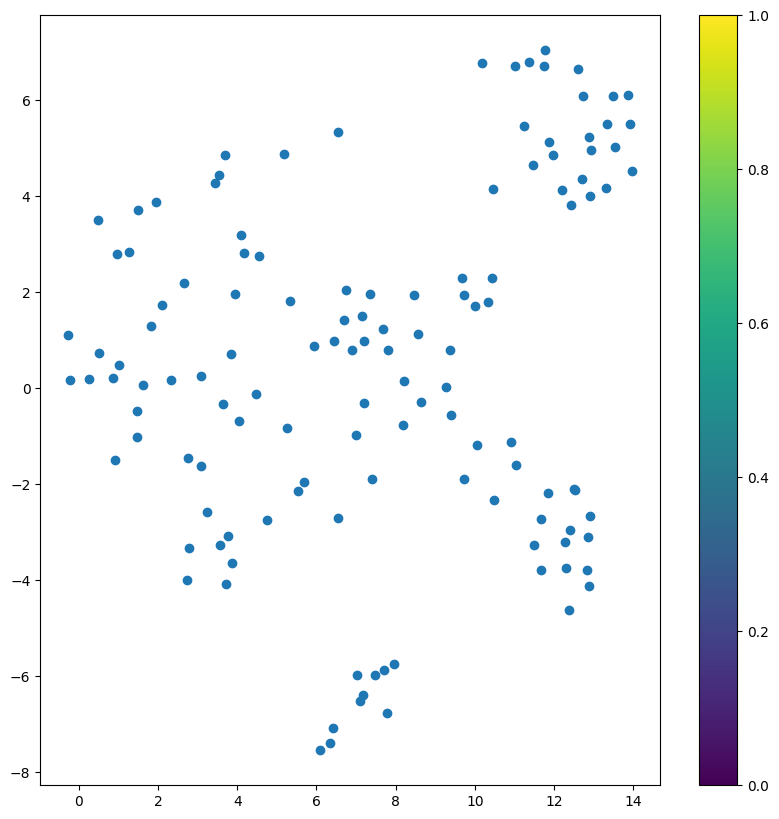

Epoch 11, Training loss 1.9485273769161087
Epoch 12, Training loss 1.9317297896088312
Epoch 13, Training loss 1.9154237892581965
Epoch 14, Training loss 1.9063177279699077
Epoch 15, Training loss 1.8910704181392564
Epoch 16, Training loss 1.8834337316342253
Epoch 17, Training loss 1.871283516192487
Epoch 18, Training loss 1.8570369344784508
Epoch 19, Training loss 1.8537013403642406
Epoch 20, Training loss 1.8462463161076055


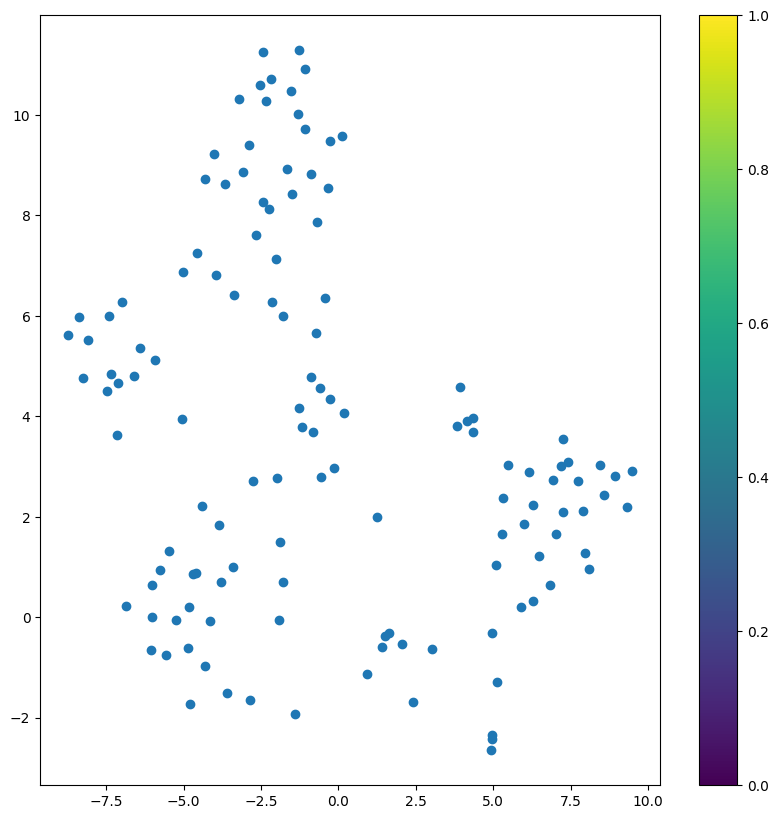

In [103]:
epochs = 20
# Train the DAE. use MSE as the loss function and 
# use Adam for the optimizer. Set the learning rate to 1e-3.
##############################
# Your code goes here (5 points)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(DAE.parameters(), lr=1e-3)
train(epochs, optimizer, DAE, loss_fn, train_loader)
##############################

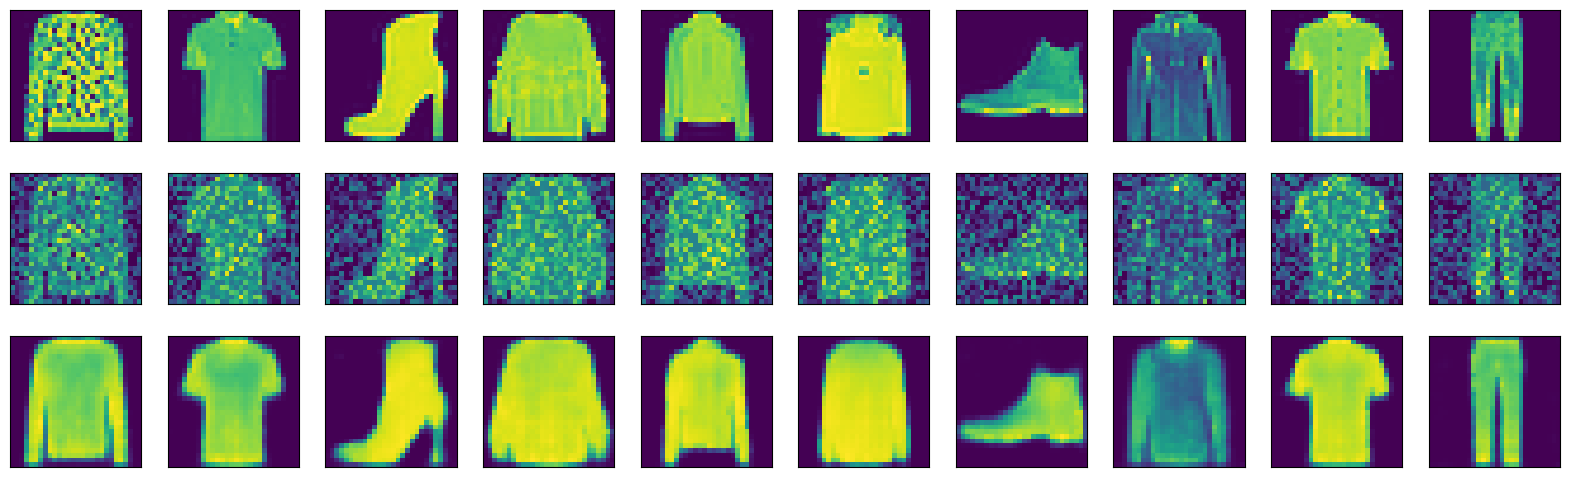

In [104]:
# Use 10 examples from the testing set to evaluate the 
# DAE's outputs visually.
##############################
# Your code goes here (5 points)
DAE.eval()

test_batch = next(iter(test_loader))
imgs, labels = test_batch
imgs = imgs.to(device)
labels = labels.to(device)




# Get the model's output on the 10 examples
with torch.no_grad():
    output = DAE(imgs.unsqueeze(1).float())

# Plot the 10 examples along with their noisy versions and the model's output
fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(20, 6))

for i in range(10):
    # Original image
    axes[0,i].imshow(labels.cpu()[i])
    axes[0,i].get_xaxis().set_visible(False)
    axes[0,i].get_yaxis().set_visible(False)
    if i == 0:
        axes[0,i].set_ylabel('Original', rotation=0, size='large')

    # Noisy image
    axes[1,i].imshow(imgs.cpu()[i])
    axes[1,i].get_xaxis().set_visible(False)
    axes[1,i].get_yaxis().set_visible(False)
    if i == 0:
        axes[1,i].set_ylabel('Noisy', rotation=0, size='large')

    # Model's output
    axes[2,i].imshow(output.cpu()[i,0])
    axes[2,i].get_xaxis().set_visible(False)
    axes[2,i].get_yaxis().set_visible(False)
    if i == 0:
        axes[2,i].set_ylabel('Output', rotation=0, size='large')

plt.show()
##############################